In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

# Use Inspector to print the column names and types
# tables: 'measurement', 'station'

columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

engine.execute('SELECT * FROM station').fetchall()


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [6]:
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
#Process of picking vacation dates - what dates are available in datebase?
# Earliest Date
session.query(Measurement.date).order_by(Measurement.date).first() #result '2010-01-01'

# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first() #result '2017-08-23'

#Vacation date range 3-15 days
# date range: '2016-06-15' to '2016-06-25'

('2017-08-23')

# Exploratory Climate Analysis

Query Date:  2016-08-28


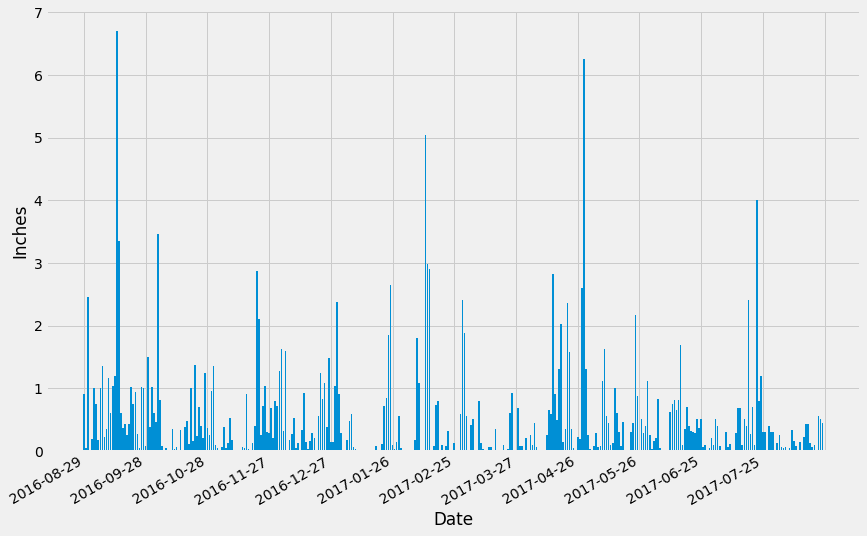

In [46]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first() #result '2017-08-23'

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=360)
# print("Query Date: ", query_date) #result '2016-08-28'

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
precip_scores = session.query(*sel).\
    filter(Measurement.date > '2016-08-28').\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precip_scores, columns=['date','prcp'])

# Sort the dataframe by date
# resource: https://stackoverflow.com/questions/28161356/sort-pandas-dataframe-by-date
df['date'] =pd.to_datetime(df.date)
df.sort_values('date') # This now sorts in date order

#clean dataframe of NaN values
df.dropna(inplace=True)

#PLOT
# convert timedate column in dateframe to string
# resource: https://stackoverflow.com/questions/28694025/converting-a-datetime-column-back-to-a-string-columns-pandas-python
df['date'] = df['date'].dt.strftime('%Y-%m-%d')

#resource: https://stackoverflow.com/questions/25279475/matplotlib-pyplot-tick-control-and-showing-date
# Defining the variables
x = df['date']
y = df['prcp'] 


plt.figure(figsize=(13, 9))
plt.xticks(np.arange(0, len(x), 30), rotation='vertical')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.bar(x,y)
plt.gcf().autofmt_xdate()
plt.show()

In [49]:
# Use Pandas to calculate the summary statistics for the precipitation data
round(df['prcp'].describe(),3)

count    1985.000
mean        0.172
std         0.453
min         0.000
25%         0.000
50%         0.020
75%         0.130
max         6.700
Name: prcp, dtype: float64

In [11]:
# Design a query to show how many stations are available in this dataset?
n = session.query(Measurement.station).count()
print(f"There are {n} of stations")

There are 19550 of stations


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

sel = [Measurement.station,
       func.count(Measurement.station)]
active_s = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()
active_s

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel = [Measurement.station,
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
temp = session.query(*sel).\
    filter(Measurement.station == "USC00519281").\
    group_by(Measurement.station).all()
temp

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

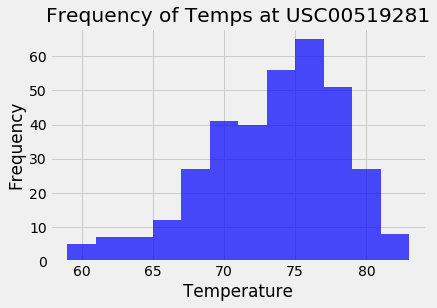

In [55]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.tobs]
results = session.query(*sel).\
    filter(Measurement.date > '2016-08-28').filter(Measurement.station == "USC00519281").\
    order_by(desc(Measurement.tobs)).all()

# Save the query results as a Pandas DataFrame
temp = [result[0] for result in results]

# the histogram of the data
n, bins, patches = plt.hist(temp, bins = 12, facecolor='blue', alpha=0.70)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Frequency of Temps at USC00519281')
plt.grid(True)

plt.show()

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
